<a href="https://colab.research.google.com/github/girisiman/Deep_Learning_Tasks/blob/master/GAN_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transf
import torchvision.utils as vutils
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [0]:
ngf = 64
ndf = 64
nz = 100
nc = 1
image_size = 64
batch_size = 64


In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        #self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4,  2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

In [28]:
G = Generator()
G

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf,4, 2,  1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)

In [30]:
D = Discriminator()
D

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [31]:
import random
seed = random.randint(1, 10000)
random.seed(seed)
torch.manual_seed(seed)


In [0]:
trans = transf.Compose([transf.Resize(image_size),
                               transf.ToTensor(),
                               transf.Normalize((0.5,), (0.5,)),
                           ])
data = dset.MNIST(root='./mnist_data/', train=True, transform=trans, download=True)
dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                         shuffle=True)
#dataloader
#dataIter = iter(dataloader)

#imgs, labels = dataIter.next()
#imgs.shape
#x = imgs.view(imgs.size(0),-1)
#print(x.size())
#for i, data in enumerate(dataloader):
        #X, _ = data[0]
        #X = X.9view(X.size(0), -1)
        #mb_size = X.size(0)
        #print(X.size())


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 1, 64, 64])


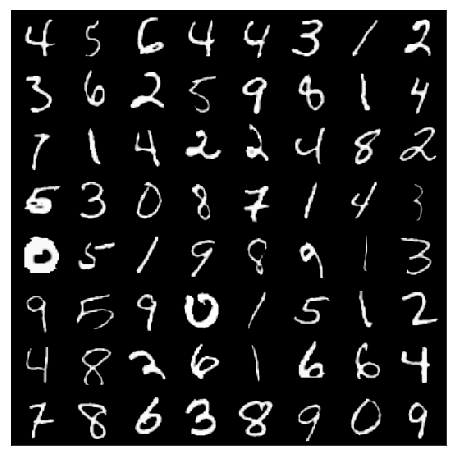

In [33]:
dataIter = iter(dataloader)
imgs, labels = dataIter.next()
print(imgs.size())

def imshow(imgs):
  import torchvision  
  imgs = torchvision.utils.make_grid(imgs)
  npimgs = imgs.numpy()
  plt.figure(figsize=(10,8))
  plt.imshow(np.transpose(npimgs, (1,2,0)), cmap='Greys_r')
  plt.xticks([])
  plt.yticks([])
  plt.savefig()
  plt.show()

imshow(imgs)

In [0]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(batch_size, nz, 1, 1)
real_label = 1
fake_label = 0

In [0]:
lr_D = 0.00005
lr_G = 0.0002
beta1 = 0.5
optimizerD = torch.optim.Adam(D.parameters(), lr=lr_D, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(G.parameters(), lr=lr_G, betas=(beta1, 0.999))

0
[0/20][0/938] Loss_D: 0.6716 Loss_G: 2.1738 D(x): 0.8069 D(G(z)): 0.3492 / 0.1269
1
[0/20][1/938] Loss_D: 0.7715 Loss_G: 1.0431 D(x): 0.5597 D(G(z)): 0.1342 / 0.3782
2
[0/20][2/938] Loss_D: 0.8053 Loss_G: 2.3239 D(x): 0.8648 D(G(z)): 0.4635 / 0.1096
3
[0/20][3/938] Loss_D: 0.6455 Loss_G: 1.4156 D(x): 0.6319 D(G(z)): 0.1452 / 0.2567
4
[0/20][4/938] Loss_D: 0.7290 Loss_G: 1.3260 D(x): 0.7267 D(G(z)): 0.3176 / 0.2813
5
[0/20][5/938] Loss_D: 0.7359 Loss_G: 1.7545 D(x): 0.7287 D(G(z)): 0.3193 / 0.1894
6
[0/20][6/938] Loss_D: 0.7061 Loss_G: 1.5810 D(x): 0.6834 D(G(z)): 0.2446 / 0.2323
7
[0/20][7/938] Loss_D: 0.6361 Loss_G: 1.6155 D(x): 0.7376 D(G(z)): 0.2614 / 0.2139
8
[0/20][8/938] Loss_D: 0.6893 Loss_G: 1.8255 D(x): 0.7574 D(G(z)): 0.3119 / 0.1785
9
[0/20][9/938] Loss_D: 0.7096 Loss_G: 1.1967 D(x): 0.6330 D(G(z)): 0.1987 / 0.3212
10
[0/20][10/938] Loss_D: 0.7514 Loss_G: 2.3863 D(x): 0.8238 D(G(z)): 0.4079 / 0.0993
11
[0/20][11/938] Loss_D: 0.7802 Loss_G: 1.2044 D(x): 0.5917 D(G(z)): 0.18

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


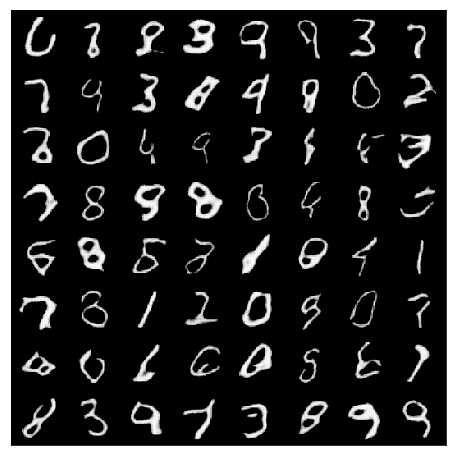

end
0
[1/20][0/938] Loss_D: 0.6556 Loss_G: 1.9656 D(x): 0.7585 D(G(z)): 0.2931 / 0.1601
1
[1/20][1/938] Loss_D: 0.6588 Loss_G: 1.2498 D(x): 0.6632 D(G(z)): 0.1941 / 0.3132
2
[1/20][2/938] Loss_D: 0.5999 Loss_G: 2.4722 D(x): 0.8783 D(G(z)): 0.3557 / 0.0981
3
[1/20][3/938] Loss_D: 0.9032 Loss_G: 0.8412 D(x): 0.5055 D(G(z)): 0.1367 / 0.4589
4
[1/20][4/938] Loss_D: 0.8070 Loss_G: 2.6867 D(x): 0.9033 D(G(z)): 0.4860 / 0.0782
5
[1/20][5/938] Loss_D: 0.6489 Loss_G: 1.5460 D(x): 0.6070 D(G(z)): 0.1139 / 0.2311
6
[1/20][6/938] Loss_D: 0.6988 Loss_G: 1.5698 D(x): 0.7541 D(G(z)): 0.3201 / 0.2317
7
[1/20][7/938] Loss_D: 0.5140 Loss_G: 2.4631 D(x): 0.8259 D(G(z)): 0.2615 / 0.0953
8
[1/20][8/938] Loss_D: 0.6901 Loss_G: 1.3645 D(x): 0.6451 D(G(z)): 0.1888 / 0.2806
9
[1/20][9/938] Loss_D: 0.6318 Loss_G: 2.0561 D(x): 0.8223 D(G(z)): 0.3315 / 0.1472
10
[1/20][10/938] Loss_D: 0.7854 Loss_G: 1.1006 D(x): 0.5839 D(G(z)): 0.1852 / 0.3602
11
[1/20][11/938] Loss_D: 0.7400 Loss_G: 2.9224 D(x): 0.8830 D(G(z)): 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


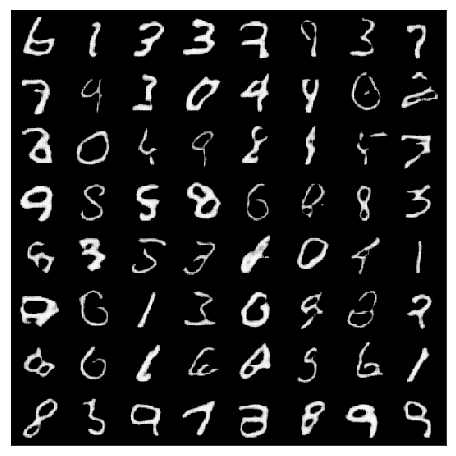

end
0
[2/20][0/938] Loss_D: 0.7366 Loss_G: 2.8821 D(x): 0.7588 D(G(z)): 0.3322 / 0.0728
1
[2/20][1/938] Loss_D: 1.1319 Loss_G: 1.2229 D(x): 0.3902 D(G(z)): 0.1009 / 0.3207
2
[2/20][2/938] Loss_D: 0.9709 Loss_G: 2.7038 D(x): 0.9131 D(G(z)): 0.5505 / 0.0780
3
[2/20][3/938] Loss_D: 0.6810 Loss_G: 2.5993 D(x): 0.7210 D(G(z)): 0.2823 / 0.0826
4
[2/20][4/938] Loss_D: 0.7595 Loss_G: 1.6071 D(x): 0.5810 D(G(z)): 0.1503 / 0.2285
5
[2/20][5/938] Loss_D: 0.8072 Loss_G: 2.7038 D(x): 0.8663 D(G(z)): 0.4591 / 0.0794
6
[2/20][6/938] Loss_D: 0.8404 Loss_G: 1.5936 D(x): 0.5481 D(G(z)): 0.1594 / 0.2257
7
[2/20][7/938] Loss_D: 0.9187 Loss_G: 2.2502 D(x): 0.7521 D(G(z)): 0.4325 / 0.1227
8
[2/20][8/938] Loss_D: 0.7157 Loss_G: 2.6709 D(x): 0.7679 D(G(z)): 0.3367 / 0.0827
9
[2/20][9/938] Loss_D: 0.9982 Loss_G: 0.9754 D(x): 0.4412 D(G(z)): 0.1063 / 0.4177
10
[2/20][10/938] Loss_D: 0.8859 Loss_G: 1.9705 D(x): 0.8810 D(G(z)): 0.4973 / 0.1610
11
[2/20][11/938] Loss_D: 0.6036 Loss_G: 2.8624 D(x): 0.8189 D(G(z)): 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


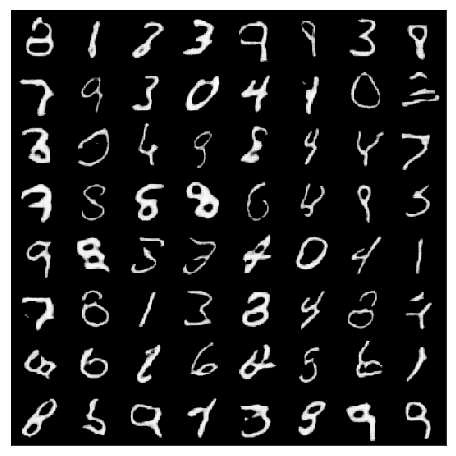

end
0
[3/20][0/938] Loss_D: 0.4064 Loss_G: 2.4195 D(x): 0.7836 D(G(z)): 0.1367 / 0.1077
1
[3/20][1/938] Loss_D: 0.3715 Loss_G: 2.3802 D(x): 0.8418 D(G(z)): 0.1660 / 0.1181
2
[3/20][2/938] Loss_D: 0.5145 Loss_G: 1.4571 D(x): 0.7286 D(G(z)): 0.1588 / 0.2604
3
[3/20][3/938] Loss_D: 0.5112 Loss_G: 2.9224 D(x): 0.9148 D(G(z)): 0.3257 / 0.0646
4
[3/20][4/938] Loss_D: 0.6543 Loss_G: 1.2160 D(x): 0.6082 D(G(z)): 0.1128 / 0.3318
5
[3/20][5/938] Loss_D: 0.6913 Loss_G: 2.4023 D(x): 0.8758 D(G(z)): 0.4024 / 0.1067
6
[3/20][6/938] Loss_D: 0.5783 Loss_G: 1.5335 D(x): 0.6723 D(G(z)): 0.1331 / 0.2405
7
[3/20][7/938] Loss_D: 0.5989 Loss_G: 2.8545 D(x): 0.8691 D(G(z)): 0.3404 / 0.0713
8
[3/20][8/938] Loss_D: 0.5087 Loss_G: 1.7101 D(x): 0.6835 D(G(z)): 0.0940 / 0.2044
9
[3/20][9/938] Loss_D: 0.4466 Loss_G: 2.0360 D(x): 0.8459 D(G(z)): 0.2265 / 0.1521
10
[3/20][10/938] Loss_D: 0.5096 Loss_G: 2.4279 D(x): 0.8261 D(G(z)): 0.2462 / 0.1057
11
[3/20][11/938] Loss_D: 0.5441 Loss_G: 1.4337 D(x): 0.6905 D(G(z)): 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


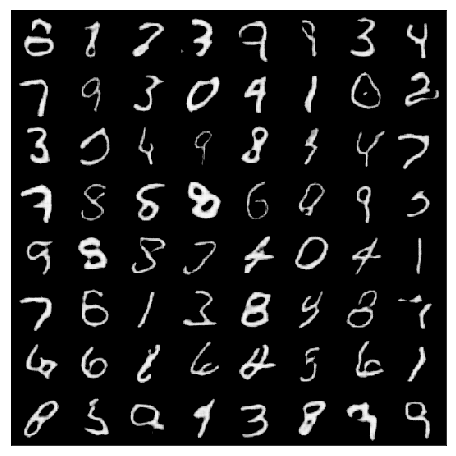

end
0
[4/20][0/938] Loss_D: 0.9901 Loss_G: 0.8540 D(x): 0.4409 D(G(z)): 0.0767 / 0.4532
1
[4/20][1/938] Loss_D: 0.9833 Loss_G: 3.5153 D(x): 0.9284 D(G(z)): 0.5602 / 0.0396
2
[4/20][2/938] Loss_D: 0.4595 Loss_G: 2.6196 D(x): 0.6923 D(G(z)): 0.0697 / 0.0918
3
[4/20][3/938] Loss_D: 0.4301 Loss_G: 1.5749 D(x): 0.7552 D(G(z)): 0.1123 / 0.2415
4
[4/20][4/938] Loss_D: 0.7113 Loss_G: 2.6236 D(x): 0.9193 D(G(z)): 0.4343 / 0.0887
5
[4/20][5/938] Loss_D: 0.5214 Loss_G: 1.9692 D(x): 0.6769 D(G(z)): 0.0982 / 0.1546
6
[4/20][6/938] Loss_D: 0.4727 Loss_G: 1.7277 D(x): 0.7917 D(G(z)): 0.1942 / 0.2041
7
[4/20][7/938] Loss_D: 0.5837 Loss_G: 2.9195 D(x): 0.8501 D(G(z)): 0.3215 / 0.0655
8
[4/20][8/938] Loss_D: 0.6740 Loss_G: 1.3699 D(x): 0.6173 D(G(z)): 0.1286 / 0.2793
9
[4/20][9/938] Loss_D: 0.6101 Loss_G: 2.8011 D(x): 0.8652 D(G(z)): 0.3538 / 0.0708
10
[4/20][10/938] Loss_D: 0.5299 Loss_G: 1.7899 D(x): 0.6841 D(G(z)): 0.1107 / 0.1964
11
[4/20][11/938] Loss_D: 0.4867 Loss_G: 2.4422 D(x): 0.8782 D(G(z)): 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


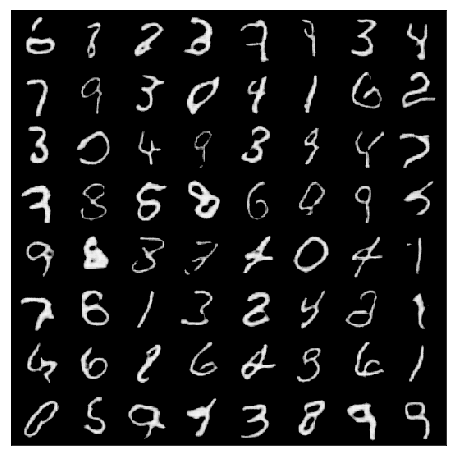

end
0
[5/20][0/938] Loss_D: 0.3097 Loss_G: 2.2549 D(x): 0.8665 D(G(z)): 0.1373 / 0.1269
1
[5/20][1/938] Loss_D: 0.6405 Loss_G: 2.3352 D(x): 0.7826 D(G(z)): 0.3010 / 0.1141
2
[5/20][2/938] Loss_D: 0.4356 Loss_G: 1.8377 D(x): 0.7363 D(G(z)): 0.1045 / 0.1884
3
[5/20][3/938] Loss_D: 0.6290 Loss_G: 3.3428 D(x): 0.8552 D(G(z)): 0.3508 / 0.0453
4
[5/20][4/938] Loss_D: 0.7975 Loss_G: 0.7448 D(x): 0.5210 D(G(z)): 0.0784 / 0.5037
5
[5/20][5/938] Loss_D: 0.8803 Loss_G: 4.2806 D(x): 0.9614 D(G(z)): 0.5337 / 0.0182
6
[5/20][6/938] Loss_D: 0.6830 Loss_G: 2.0147 D(x): 0.5501 D(G(z)): 0.0341 / 0.1636
7
[5/20][7/938] Loss_D: 0.4133 Loss_G: 2.4854 D(x): 0.9368 D(G(z)): 0.2751 / 0.1022
8
[5/20][8/938] Loss_D: 0.3613 Loss_G: 2.9980 D(x): 0.8806 D(G(z)): 0.1979 / 0.0595
9
[5/20][9/938] Loss_D: 0.5827 Loss_G: 1.5408 D(x): 0.6893 D(G(z)): 0.1643 / 0.2446
10
[5/20][10/938] Loss_D: 0.7828 Loss_G: 2.2471 D(x): 0.7682 D(G(z)): 0.3720 / 0.1258
11
[5/20][11/938] Loss_D: 0.5223 Loss_G: 2.0081 D(x): 0.7016 D(G(z)): 

KeyboardInterrupt: ignored

In [37]:
n_epoch =20
for epoch in range(20):
    err_d_run = 0.0
    err_g_run = 0.0
    for i, data in enumerate(dataloader, 0):
        print(i)
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        D.zero_grad()
        images, _ = data
        x = data[0]
        #print(x.size())
        batch_size = x.size(0)
        #real_cpu = data[0].to(device)
        #batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label)

        output = D(x)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1)
        fake = G(noise)
        label.fill_(fake_label)
        output = D(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = D(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        current_step = i + epoch*len(dataloader)
        err_d_run += errD.item()
        err_g_run += errG.item()
        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, n_epoch, i, len(dataloader),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
    print('Epoch:{},   G_loss:{},    D_loss:{}'.format(epoch, err_g_run/(i+1), err_d_run/(i+1)))
    samples = G(fixed_noise).detach()
    samples = samples.view(samples.size(0), 1, 64, 64).cpu()
    imshow(samples)
    print('end')

In [0]:
def outputSize(in_size, kernel_size, stride, padding):
  output = int((in_size - kernel_size + 2*(padding)) / stride) + 1
  return(output)

In [0]:
o/p = outputSize()